In [0]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time 

import pandas as pd

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available. Training on CPU ...

# Import Data

References: <br>
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html <br>
https://datahacker.rs/009-pytorch-building-an-artificial-neural-network-with-perceprton-on-cifar10-using-pytorch/ <br>
https://datahacker.rs/005-pytorch-convolutional-neural-network-on-mnist-in-pytorch/ <br>
https://www.kaggle.com/shadabhussain/cifar-10-cnn-using-pytorch/notebook

In [0]:
#load data and convert to tensors
path = '../data_cifar/'
train_set = CIFAR10(path, train=True, download=True, transform=transforms.ToTensor())
test_set = CIFAR10(path, train=False, download=True, transform=transforms.ToTensor())

print ("Train size: {}, Test size: {}".format(len(train_set), len(test_set)))



Files already downloaded and verified
Files already downloaded and verified
Train size: 50000, Test size: 10000

torch.Size([3, 32, 32]) 6
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
bird
Out[338]:

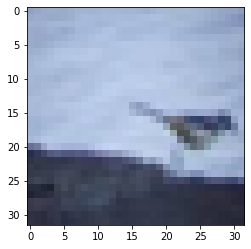

<matplotlib.image.AxesImage at 0x7f69876d0550>

In [0]:
#inspect data 
print(train_set[0][0].shape, train_set[0][1])

print(train_set.classes)

data, label = train_set[-5]
print(train_set.classes[label])

plt.imshow(data.permute((1, 2, 0))) #reshapes 3 x 32 x 32 to 32 x 32 x 3

### Define constants

In [0]:
INPUT_SIZE = 32*32*3
NUM_CLASSES = 10
SEED = 97
TRAIN_BATCH_SIZE = 100  
TEST_BATCH_SIZE = 500
VAL_SET_SIZE = 5000

torch.manual_seed(SEED)


Out[339]: <torch._C.Generator at 0x7f6964299630>

In [0]:
v = VAL_SET_SIZE
t = (len(train_set)-VAL_SET_SIZE)
print(t, " ",  v)

45000 5000

In [0]:
#create validation set 
train_set, val_set = random_split(train_set, [(len(train_set)-VAL_SET_SIZE), VAL_SET_SIZE] )
print(f'Train set: {len(train_set)}, Validation set: {len(val_set)}')

Train set: 45000, Validation set: 5000

In [0]:
#set up data loader to load in batches
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size = TEST_BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_set, batch_size=TEST_BATCH_SIZE, shuffle=False)

# Helper Functions

In [0]:
def train_NN(model, num_epochs, optimizer_fxn, loss_fxn, isCNN = False):
  
  time_start = time.time()
  
  train_metrics = pd.DataFrame(columns = ['epoch', 't_loss', 't_accuracy', 'v_loss', 'v_accuracy'])
  
  #for each epoch
  for i in range(0, num_epochs):
    
    correct_pred_train = 0 #for epoch 
    correct_pred_val = 0 #for epoch
    
    #for each batch 
    batch_num = 1 
    for X_train, y_train in train_loader:
      
      #forward pass 
      if isCNN:
        y_out = model(X_train)
      else:
        y_out = model(X_train.view(TRAIN_BATCH_SIZE, -1)) #flattens data
        
      #calculate loss
      loss = loss_fxn(y_out, y_train)
      #calculate predicted class
      y_pred = torch.max(y_out.data, 1)[1]
      #calculate number of correct predictions 
      correct_pred = (y_pred == y_train).sum() #for batch 
      correct_pred_train += correct_pred 
      
      #backward pass 
      optimizer_fxn.zero_grad() #resetgradients to 0 
      loss.backward()
      #calculate gradients 
      optimizer_fxn.step()
       
      if batch_num%100 == 0:
        #print("correct pred: {}, batch num : {}".format(correct_pred_train, batch_num))
        print("epoch {} batch {}------loss: {} accuracy: {} %".format(i, batch_num, loss, round((correct_pred_train.item()/(TRAIN_BATCH_SIZE*batch_num))*100, 3) ))
        
      batch_num += 1
      
    
    accuracy = (correct_pred_train.item()/(TRAIN_BATCH_SIZE*batch_num))*100 
    
    
    #check performance against validation set
    with torch.no_grad():
      
      for X_val, y_val in val_loader:
        #forward pass 
        if isCNN:
          y_out = model(X_val)
        else:
          y_out = model(X_val.view(TEST_BATCH_SIZE, -1)) #flattens data
          
        #get predicted class   
        y_pred = torch.max(y_out.data, 1)[1]
        correct_pred_val += (y_pred == y_val).sum()
        
    #calculate validation accuracy + loss    
    loss_val = loss_fxn(y_out, y_val)
    v_accuracy = (correct_pred_val.item()/VAL_SET_SIZE)*100
    
    #save result
    new_result = {'epoch': i+1, 't_loss': loss.item(), 't_accuracy': accuracy, 'v_loss': loss_val.item(), 'v_accuracy': v_accuracy } 
    train_metrics = train_metrics.append(new_result, ignore_index = True)
  
  time_elapsed = time.time() - time_start
  print("total time elapsed: {} s".format(round(time_elapsed,2)))
  
  return model, train_metrics, time_elapsed 


def test_NN(model, loss_fxn, isCNN = False):
  
  time_start = time.time()
  correct_pred_test = 0 
  all_pred = torch.Tensor()
  y_actual = torch.Tensor()
  
  with torch.no_grad():
    
    batch_num = 1
    for X_test, y_test in test_loader:
      #forward pass 
      if isCNN:
        y_out = model(X_test)
      else:
        y_out = model(X_test.view(TEST_BATCH_SIZE, -1)) #flattens image
      #print(X_test.view(TEST_BATCH_SIZE, -1).shape)
      #get predicted class   
      y_pred = torch.max(y_out.data, 1)[1]
      y_actual = torch.cat((y_actual, y_test), 0) 
      all_pred = torch.cat((all_pred, y_pred), 0) 
      #calculate loss 
      loss = loss_fxn(y_out, y_test)
      #calculate number of correct predictions 
      correct_pred = (y_pred == y_test).sum() #for batch 
      correct_pred_test += correct_pred 
      
      batch_num += batch_num 
         
  time_elapsed = round(time.time() - time_start, 2) 
  accuracy = round((correct_pred_test.item()/len(test_set))*100, 2)
  
  print(f'Test set: \nTime elapsed: {time_elapsed} s Accuracy: {accuracy} ') #loss: {loss}
    
  return time_elapsed, loss, accuracy, all_pred, y_actual

def plot_confusion_matrix(cm):
  fig = plt.figure(figsize=(16,5))   
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(test_set.classes);
  ax.yaxis.set_ticklabels(test_set.classes);
  ax.tick_params(axis='y', rotation=30)

def plot_accuracy_loss(train_metrics):
  fig = plt.figure(figsize=(16,5))                                  
  ax1 = fig.add_subplot(121)
  sns.lineplot(data=train_metrics, x="epoch", y="t_loss")
  sns.lineplot(data=train_metrics, x="epoch", y="v_loss")
  plt.legend(['Training set', 'Validation set'])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  ax1.set_title('Training set: Loss')
  ax2 = fig.add_subplot(122)
  sns.lineplot(data=train_metrics, x="epoch", y="t_accuracy")
  sns.lineplot(data=train_metrics, x="epoch", y="v_accuracy")
  plt.legend(['Training set', 'Validation set'])
  plt.xlabel('epoch')
  plt.ylabel('accuracy % ')
  ax2.set_title('Training set: Accuracy')
  None

# Neural Network

In [0]:
#Define network architecture
class FCNeuralNetwork(nn.Module):

    def __init__(self, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1024) #  input layer 
        self.fc2 = nn.Linear(1024, 512) #size = 1024
        self.fc3 = nn.Linear(512, 256) #size = 512
        self.fc4 = nn.Linear(256, 64) #size = 256
        self.fc5 = nn.Linear(64, output_size) #size = 64

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X)) #self.fc5(X)
        return X #F.log_softmax(X, dim=1) 
      

## Optimizers

### SGD

learning rate = 0.05

In [0]:
model = FCNeuralNetwork()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 15, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 200------loss: 2.2906267642974854 accuracy: 13.305 %
epoch 0 batch 400------loss: 2.290973424911499 accuracy: 15.155 %
epoch 1 batch 200------loss: 2.1704039573669434 accuracy: 20.655 %
epoch 1 batch 400------loss: 2.0910370349884033 accuracy: 22.193 %
epoch 2 batch 200------loss: 2.1460657119750977 accuracy: 25.655 %
epoch 2 batch 400------loss: 2.1600894927978516 accuracy: 26.28 %
epoch 3 batch 200------loss: 1.9636545181274414 accuracy: 28.22 %
epoch 3 batch 400------loss: 2.0356712341308594 accuracy: 28.165 %
epoch 4 batch 200------loss: 1.906211256980896 accuracy: 29.155 %
epoch 4 batch 400------loss: 2.102492094039917 accuracy: 29.497 %
epoch 5 batch 200------loss: 1.9916361570358276 accuracy: 31.36 %
epoch 5 batch 400------loss: 1.9304176568984985 accuracy: 31.238 %
epoch 6 batch 200------loss: 1.8761402368545532 accuracy: 32.505 %
epoch 6 batch 400------loss: 1.9558714628219604 accuracy: 32.64 %
epoch 7 batch 200------loss: 1.9944214820861816 accuracy: 33.635 %
epoch 7 batch 400------loss: 1.9330955743789673 accuracy: 33.56 %
epoch 8 batch 200------loss: 1.942111849784851 accuracy: 33.175 %
epoch 8 batch 400------loss: 2.022116184234619 accuracy: 33.657 %
epoch 9 batch 200------loss: 1.9896676540374756 accuracy: 34.385 %
epoch 9 batch 400------loss: 1.8880847692489624 accuracy: 34.57 %
epoch 10 batch 200------loss: 1.7701166868209839 accuracy: 35.935 %
epoch 10 batch 400------loss: 1.8266777992248535 accuracy: 35.575 %
epoch 11 batch 200------loss: 1.9612078666687012 accuracy: 36.355 %
epoch 11 batch 400------loss: 1.789833426475525 accuracy: 35.998 %
epoch 12 batch 200------loss: 1.783791184425354 accuracy: 38.88 %
epoch 12 batch 400------loss: 1.6499457359313965 accuracy: 39.242 %
epoch 13 batch 200------loss: 1.728822946548462 accuracy: 40.395 %
epoch 13 batch 400------loss: 1.6922614574432373 accuracy: 40.38 %
epoch 14 batch 200------loss: 1.8746250867843628 accuracy: 41.47 %
epoch 14 batch 400------loss: 1.5587979555130005 accuracy: 42.185 %
total time elapsed: 147.78 s

Time elapsed for training: 2.463 min, Accuracy: 42.2 %

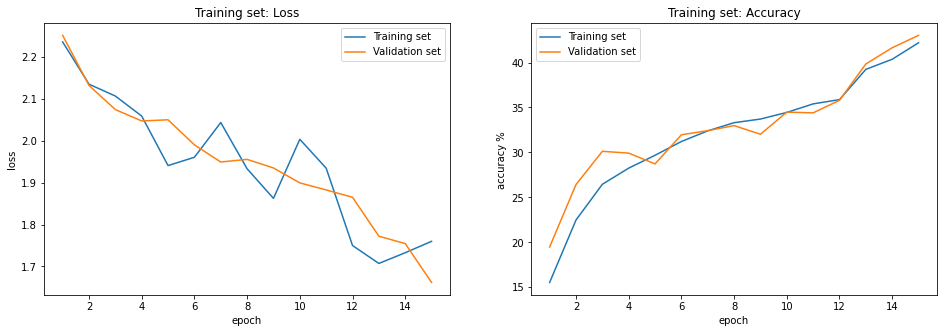

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )

plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.18 s Accuracy: 42.57

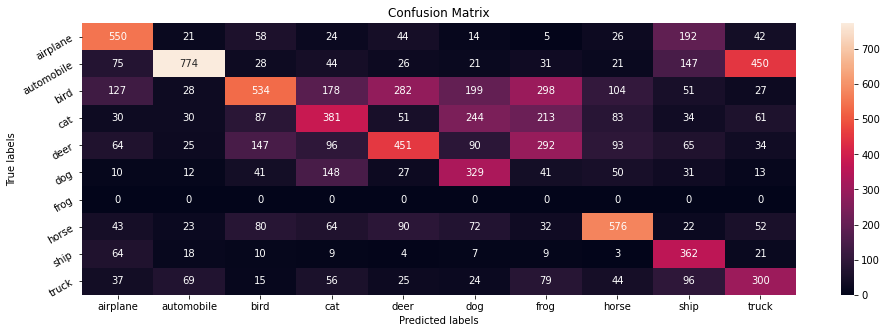

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)

cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

learning rate = 0.005

In [0]:
model = FCNeuralNetwork()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 15, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 200------loss: 2.2536661624908447 accuracy: 14.575 %
epoch 0 batch 400------loss: 2.1267666816711426 accuracy: 16.59 %
epoch 1 batch 200------loss: 2.1117465496063232 accuracy: 23.76 %
epoch 1 batch 400------loss: 2.130463123321533 accuracy: 25.33 %
epoch 2 batch 200------loss: 2.064493179321289 accuracy: 29.215 %
epoch 2 batch 400------loss: 1.9728899002075195 accuracy: 29.59 %
epoch 3 batch 200------loss: 1.849562168121338 accuracy: 31.295 %
epoch 3 batch 400------loss: 1.977705717086792 accuracy: 31.59 %
epoch 4 batch 200------loss: 1.8095985651016235 accuracy: 33.245 %
epoch 4 batch 400------loss: 1.8693078756332397 accuracy: 33.322 %
epoch 5 batch 200------loss: 1.9925587177276611 accuracy: 34.02 %
epoch 5 batch 400------loss: 2.020098924636841 accuracy: 34.558 %
epoch 6 batch 200------loss: 1.8882455825805664 accuracy: 35.745 %
epoch 6 batch 400------loss: 1.8778094053268433 accuracy: 35.593 %
epoch 7 batch 200------loss: 2.0753955841064453 accuracy: 36.45 %
epoch 7 batch 400------loss: 1.778866171836853 accuracy: 36.773 %
epoch 8 batch 200------loss: 1.7852047681808472 accuracy: 37.325 %
epoch 8 batch 400------loss: 1.8183540105819702 accuracy: 37.45 %
epoch 9 batch 200------loss: 1.671329379081726 accuracy: 38.455 %
epoch 9 batch 400------loss: 1.8847938776016235 accuracy: 38.505 %
epoch 10 batch 200------loss: 1.711672067642212 accuracy: 38.92 %
epoch 10 batch 400------loss: 1.8631045818328857 accuracy: 38.885 %
epoch 11 batch 200------loss: 1.7116539478302002 accuracy: 39.45 %
epoch 11 batch 400------loss: 1.8704115152359009 accuracy: 39.733 %
epoch 12 batch 200------loss: 1.5444424152374268 accuracy: 42.8 %
epoch 12 batch 400------loss: 1.6526347398757935 accuracy: 42.943 %
epoch 13 batch 200------loss: 1.4762059450149536 accuracy: 44.135 %
epoch 13 batch 400------loss: 1.741455078125 accuracy: 44.07 %
epoch 14 batch 200------loss: 1.8089399337768555 accuracy: 44.705 %
epoch 14 batch 400------loss: 1.823516845703125 accuracy: 45.005 %
total time elapsed: 148.23 s

Time elapsed for training: 2.517 min, Accuracy: 42.64 %

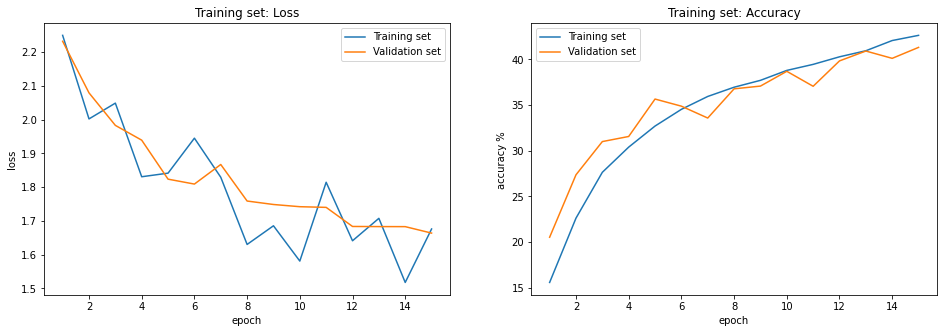

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )

plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.29 s Accuracy: 41.71

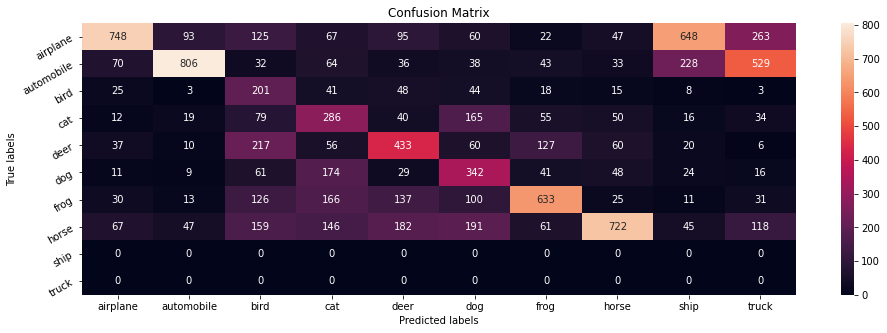

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)

cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

### Adam

learning rate = 0.001

In [0]:
model = FCNeuralNetwork()
loss = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(model.parameters(), lr = 0.001 )

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 8, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 200------loss: 2.1342933177948 accuracy: 19.71 %
epoch 0 batch 400------loss: 2.0998034477233887 accuracy: 23.485 %
epoch 1 batch 200------loss: 1.9933987855911255 accuracy: 30.05 %
epoch 1 batch 400------loss: 1.818190574645996 accuracy: 31.175 %
epoch 2 batch 200------loss: 1.7207201719284058 accuracy: 35.435 %
epoch 2 batch 400------loss: 1.8613269329071045 accuracy: 36.36 %
epoch 3 batch 200------loss: 1.6004737615585327 accuracy: 39.06 %
epoch 3 batch 400------loss: 1.7226409912109375 accuracy: 40.07 %
epoch 4 batch 200------loss: 1.6197181940078735 accuracy: 42.475 %
epoch 4 batch 400------loss: 1.7510088682174683 accuracy: 42.865 %
epoch 5 batch 200------loss: 1.4385703802108765 accuracy: 45.265 %
epoch 5 batch 400------loss: 1.3887182474136353 accuracy: 45.03 %
epoch 6 batch 200------loss: 1.6805180311203003 accuracy: 46.3 %
epoch 6 batch 400------loss: 1.5193477869033813 accuracy: 46.56 %
epoch 7 batch 200------loss: 1.4081286191940308 accuracy: 47.915 %
epoch 7 batch 400------loss: 1.3700391054153442 accuracy: 47.902 %
total time elapsed: 163.55 s

Time elapsed for training: 2.726 min, Accuracy: 47.75 %

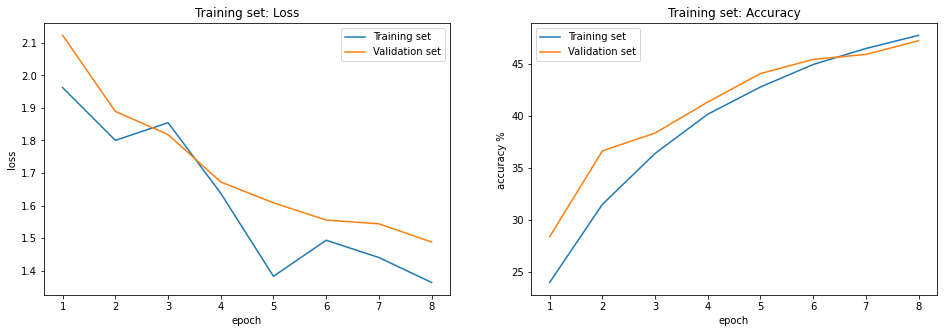

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )

plot_accuracy_loss(train_metrics)


Test set: 
Time elapsed: 1.48 s Accuracy: 46.58

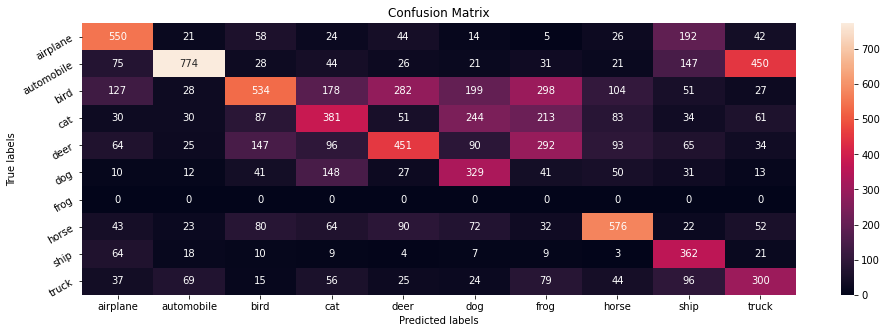

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)

plot_confusion_matrix(cm)


learning rate = 0.002

In [0]:
model = FCNeuralNetwork()
loss = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(model.parameters(), lr = 0.0005 )

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 8, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 200------loss: 2.1290500164031982 accuracy: 19.915 %
epoch 0 batch 400------loss: 1.9111326932907104 accuracy: 23.275 %
epoch 1 batch 200------loss: 2.0444581508636475 accuracy: 30.17 %
epoch 1 batch 400------loss: 1.9105093479156494 accuracy: 31.18 %
epoch 2 batch 200------loss: 2.023879051208496 accuracy: 33.48 %
epoch 2 batch 400------loss: 1.886584758758545 accuracy: 33.73 %
epoch 3 batch 200------loss: 1.8313469886779785 accuracy: 35.19 %
epoch 3 batch 400------loss: 1.8190563917160034 accuracy: 35.065 %
epoch 4 batch 200------loss: 1.9168678522109985 accuracy: 36.86 %
epoch 4 batch 400------loss: 1.8243240118026733 accuracy: 36.83 %
epoch 5 batch 200------loss: 1.8053518533706665 accuracy: 37.3 %
epoch 5 batch 400------loss: 1.8078597784042358 accuracy: 37.683 %
epoch 6 batch 200------loss: 1.967698574066162 accuracy: 38.185 %
epoch 6 batch 400------loss: 1.8063173294067383 accuracy: 38.475 %
epoch 7 batch 200------loss: 1.7361326217651367 accuracy: 39.915 %
epoch 7 batch 400------loss: 1.8058720827102661 accuracy: 39.612 %
total time elapsed: 142.64 s

Time elapsed for training: 2.377 min, Accuracy: 39.53 %

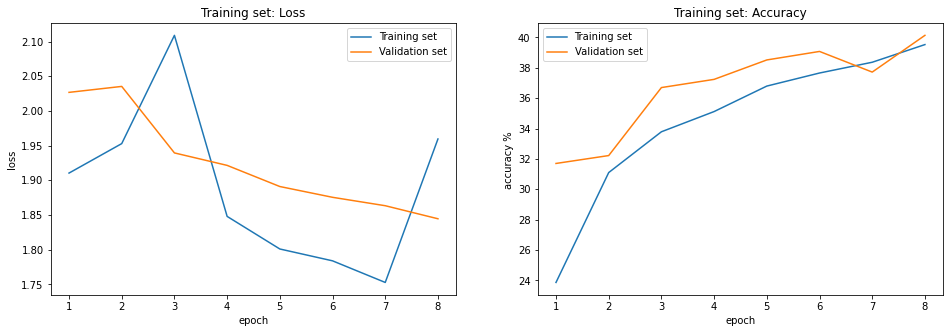

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )

plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.24 s Accuracy: 38.4

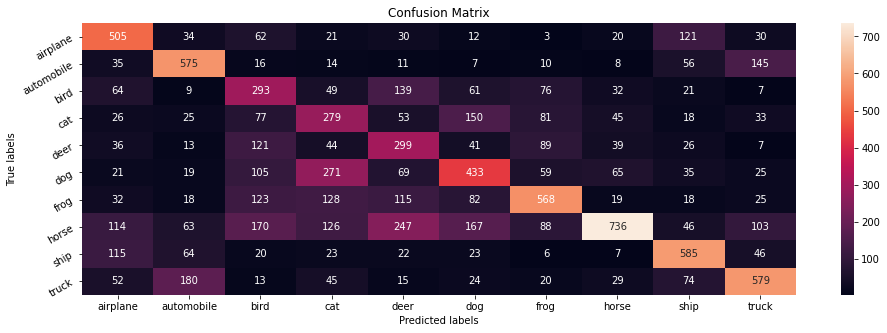

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)

plot_confusion_matrix(cm)


# add dropout

In [0]:
#Define network architecture
class NeuralNetwork(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.linear_layers = nn.Sequential(
        nn.Linear(input_size, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.linear_layers(X)
        #calculate probabiliy distributions
        return  X #F.log_softmax(X, dim=1)

## P = 0.1

In [0]:
model = NeuralNetwork(dropout=0.1)
#print(model)
#for name,param in model.named_parameters():
#  print(name, ":", param.numel())

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 12, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 200------loss: 1.9651423692703247 accuracy: 21.32 %
epoch 0 batch 400------loss: 1.896024465560913 accuracy: 25.705 %
epoch 1 batch 200------loss: 1.8316543102264404 accuracy: 32.955 %
epoch 1 batch 400------loss: 1.9305363893508911 accuracy: 33.948 %
epoch 2 batch 200------loss: 1.6448757648468018 accuracy: 37.295 %
epoch 2 batch 400------loss: 1.6456573009490967 accuracy: 37.797 %
epoch 3 batch 200------loss: 1.6017401218414307 accuracy: 39.485 %
epoch 3 batch 400------loss: 1.6656906604766846 accuracy: 39.383 %
epoch 4 batch 200------loss: 1.441001296043396 accuracy: 41.17 %
epoch 4 batch 400------loss: 1.7061511278152466 accuracy: 41.54 %
epoch 5 batch 200------loss: 1.881648302078247 accuracy: 42.435 %
epoch 5 batch 400------loss: 1.464503288269043 accuracy: 42.432 %
epoch 6 batch 200------loss: 1.5640658140182495 accuracy: 44.13 %
epoch 6 batch 400------loss: 1.4161460399627686 accuracy: 44.01 %
epoch 7 batch 200------loss: 1.5816541910171509 accuracy: 45.035 %
epoch 7 batch 400------loss: 1.6721464395523071 accuracy: 45.04 %
epoch 8 batch 200------loss: 1.3942773342132568 accuracy: 45.605 %
epoch 8 batch 400------loss: 1.4908593893051147 accuracy: 45.36 %
epoch 9 batch 200------loss: 1.8177621364593506 accuracy: 46.455 %
epoch 9 batch 400------loss: 1.5621753931045532 accuracy: 46.395 %
epoch 10 batch 200------loss: 1.4846546649932861 accuracy: 46.845 %
epoch 10 batch 400------loss: 1.4543015956878662 accuracy: 46.958 %
epoch 11 batch 200------loss: 1.3866090774536133 accuracy: 48.23 %
epoch 11 batch 400------loss: 1.28322172164917 accuracy: 48.008 %
total time elapsed: 219.23 s

Time elapsed for training: 3.654 min, Accuracy: 47.92 %

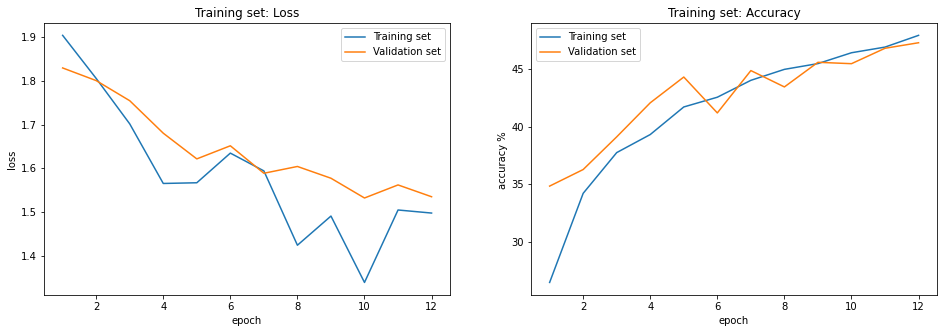

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.16 s Accuracy: 46.89

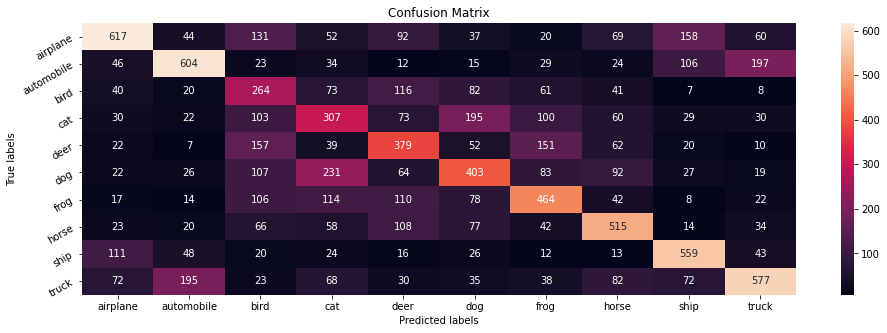

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

## P = 0.3

In [0]:
model = NeuralNetwork(dropout=0.3)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 12, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 200------loss: 2.0577142238616943 accuracy: 16.315 %
epoch 0 batch 400------loss: 1.989466905593872 accuracy: 19.887 %
epoch 1 batch 200------loss: 2.0580990314483643 accuracy: 28.555 %
epoch 1 batch 400------loss: 1.975825309753418 accuracy: 29.2 %
epoch 2 batch 200------loss: 1.9107776880264282 accuracy: 30.82 %
epoch 2 batch 400------loss: 1.9400895833969116 accuracy: 31.33 %
epoch 3 batch 200------loss: 1.7204478979110718 accuracy: 32.14 %
epoch 3 batch 400------loss: 1.6828079223632812 accuracy: 32.773 %
epoch 4 batch 200------loss: 1.905672311782837 accuracy: 33.715 %
epoch 4 batch 400------loss: 1.875043511390686 accuracy: 33.965 %
epoch 5 batch 200------loss: 1.667487621307373 accuracy: 34.97 %
epoch 5 batch 400------loss: 1.7109674215316772 accuracy: 35.335 %
epoch 6 batch 200------loss: 1.8251686096191406 accuracy: 35.765 %
epoch 6 batch 400------loss: 1.7946791648864746 accuracy: 36.087 %
epoch 7 batch 200------loss: 1.7380253076553345 accuracy: 37.165 %
epoch 7 batch 400------loss: 1.769508957862854 accuracy: 37.075 %
epoch 8 batch 200------loss: 1.6523112058639526 accuracy: 37.845 %
epoch 8 batch 400------loss: 1.6225883960723877 accuracy: 37.61 %
epoch 9 batch 200------loss: 1.8066285848617554 accuracy: 37.855 %
epoch 9 batch 400------loss: 1.6570734977722168 accuracy: 38.24 %
epoch 10 batch 200------loss: 1.7017773389816284 accuracy: 38.725 %
epoch 10 batch 400------loss: 1.650589108467102 accuracy: 38.793 %
epoch 11 batch 200------loss: 1.7173658609390259 accuracy: 39.29 %
epoch 11 batch 400------loss: 1.692754864692688 accuracy: 39.608 %
total time elapsed: 221.39 s

Time elapsed for training: 3.69 min, Accuracy: 39.44 %

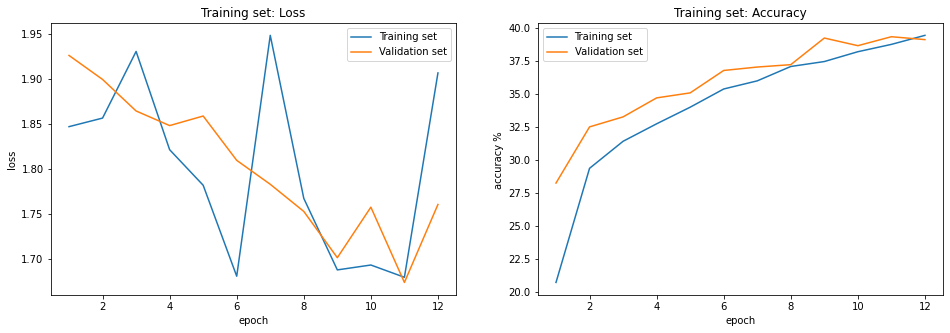

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.2 s Accuracy: 39.82

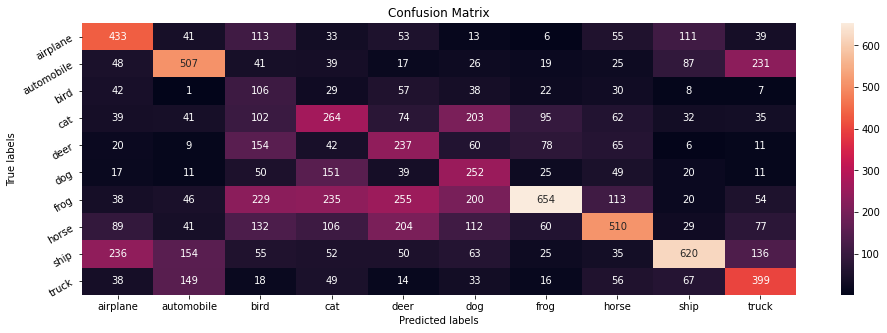

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

## P = 0.05

In [0]:
model = NeuralNetwork(dropout=0.05)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 12, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 200------loss: 1.9761103391647339 accuracy: 22.285 %
epoch 0 batch 400------loss: 1.8208874464035034 accuracy: 26.968 %
epoch 1 batch 200------loss: 2.027273654937744 accuracy: 34.615 %
epoch 1 batch 400------loss: 1.848254680633545 accuracy: 35.48 %
epoch 2 batch 200------loss: 1.6046637296676636 accuracy: 38.285 %
epoch 2 batch 400------loss: 1.6515488624572754 accuracy: 38.852 %
epoch 3 batch 200------loss: 1.6837750673294067 accuracy: 41.14 %
epoch 3 batch 400------loss: 1.5542303323745728 accuracy: 41.602 %
epoch 4 batch 200------loss: 1.6237173080444336 accuracy: 42.655 %
epoch 4 batch 400------loss: 1.3588454723358154 accuracy: 42.915 %
epoch 5 batch 200------loss: 1.5680829286575317 accuracy: 43.825 %
epoch 5 batch 400------loss: 1.6386027336120605 accuracy: 44.01 %
epoch 6 batch 200------loss: 1.4782958030700684 accuracy: 45.635 %
epoch 6 batch 400------loss: 1.2479535341262817 accuracy: 45.517 %
epoch 7 batch 200------loss: 1.3538583517074585 accuracy: 46.205 %
epoch 7 batch 400------loss: 1.1765369176864624 accuracy: 46.645 %
epoch 8 batch 200------loss: 1.5082788467407227 accuracy: 48.485 %
epoch 8 batch 400------loss: 1.4312376976013184 accuracy: 47.977 %
epoch 9 batch 200------loss: 1.561173439025879 accuracy: 48.47 %
epoch 9 batch 400------loss: 1.304078221321106 accuracy: 48.94 %
epoch 10 batch 200------loss: 1.2847542762756348 accuracy: 49.77 %
epoch 10 batch 400------loss: 1.4413015842437744 accuracy: 49.595 %
epoch 11 batch 200------loss: 1.2502316236495972 accuracy: 50.315 %
epoch 11 batch 400------loss: 1.376956820487976 accuracy: 50.267 %
total time elapsed: 220.78 s

Time elapsed for training: 3.68 min, Accuracy: 50.19 %

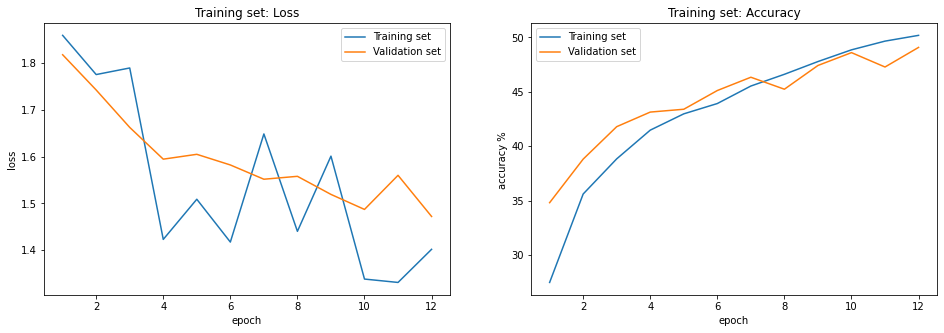

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.61 s Accuracy: 48.52

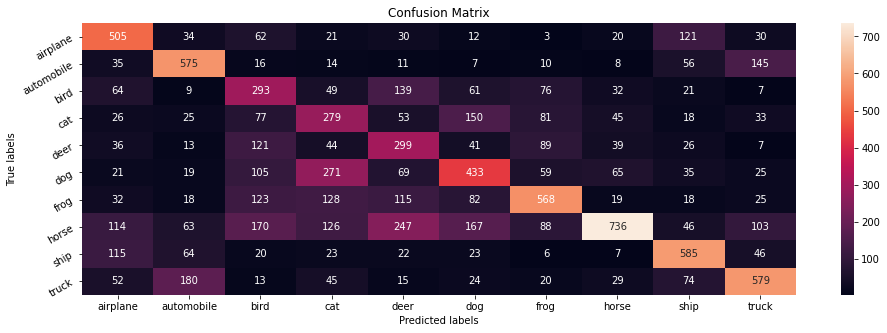

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

# Convolution Layers

## 2 conv layers

In [0]:
#Define network architecture
class CNN(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - 3)/1 + 1 = 32
          nn.MaxPool2d(kernel_size=2),
          # 32 / 2 = 16
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
          #output layer = (16 + 2*1 - 3)/1 + 1 = 16
          nn.MaxPool2d(kernel_size=2)
          # 16 / 2 = 8        
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(24*8*8, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 3, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)


epoch 0 batch 200------loss: 1.6204746961593628 accuracy: 25.495 %
epoch 0 batch 400------loss: 1.3335016965866089 accuracy: 33.932 %
epoch 1 batch 200------loss: 1.3282939195632935 accuracy: 54.105 %
epoch 1 batch 400------loss: 1.1115076541900635 accuracy: 55.66 %
epoch 2 batch 200------loss: 1.1099746227264404 accuracy: 63.37 %
epoch 2 batch 400------loss: 0.9605600833892822 accuracy: 64.1 %
total time elapsed: 53.09 s

Time elapsed for training: 0.885 min, Accuracy: 64.16 %

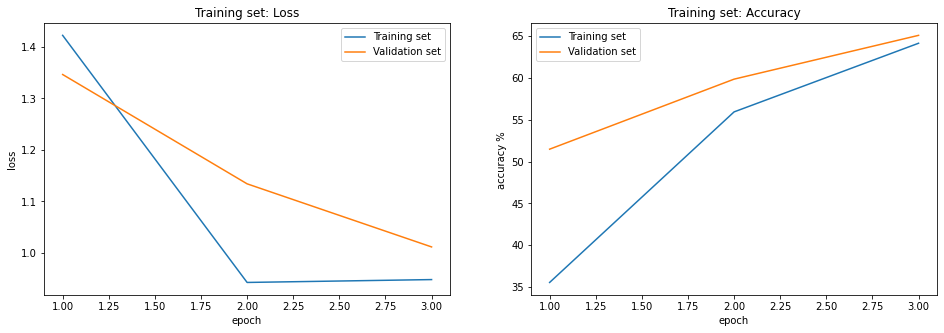

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.63 s Accuracy: 63.59

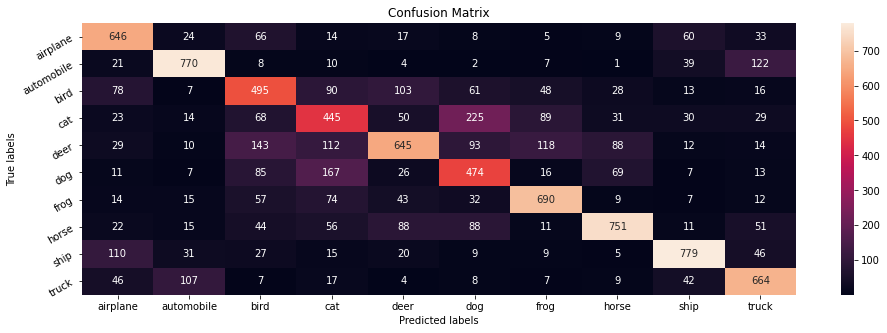

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

## 3 conv layers

In [0]:
#Define network architecture
class CNN_3(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - 3)/1 + 1 = 32
          nn.MaxPool2d(kernel_size=2),
          # 32 / 2 = 16
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
          #output layer = (16 + 2*1 - 3)/1 + 1 = 16
          nn.MaxPool2d(kernel_size=2),
          # 16 / 2 = 8  
          nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1, stride=1),
          #output layer = (8 + 2*1 - 3)/1 + 1 = 8
          nn.MaxPool2d(kernel_size=2),
          # 8 / 2 = 4  
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(64*4*4, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN_3()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 5, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 200------loss: 1.5920660495758057 accuracy: 26.955 %
epoch 0 batch 400------loss: 1.4760468006134033 accuracy: 35.65 %
epoch 1 batch 200------loss: 1.2663788795471191 accuracy: 55.11 %
epoch 1 batch 400------loss: 1.3564021587371826 accuracy: 57.002 %
epoch 2 batch 200------loss: 1.1016666889190674 accuracy: 65.115 %
epoch 2 batch 400------loss: 0.9840467572212219 accuracy: 65.815 %
epoch 3 batch 200------loss: 0.7959902286529541 accuracy: 72.36 %
epoch 3 batch 400------loss: 0.7488000392913818 accuracy: 72.635 %
epoch 4 batch 200------loss: 0.6528025269508362 accuracy: 78.395 %
epoch 4 batch 400------loss: 0.6148961782455444 accuracy: 78.135 %
total time elapsed: 88.68 s

Time elapsed for training: 1.478 min, Accuracy: 77.81 %

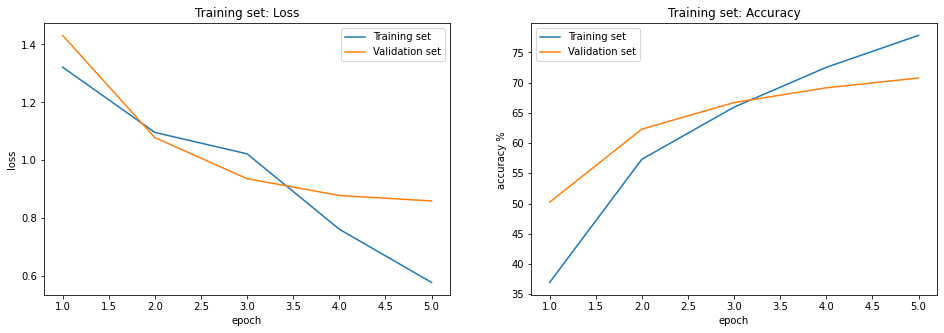

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.84 s Accuracy: 70.64

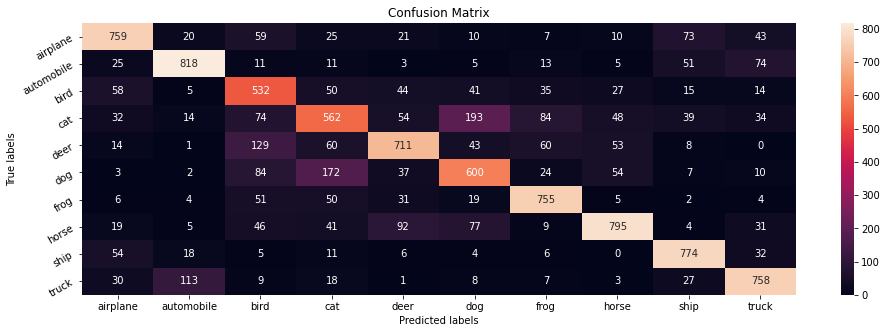

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

### add dropout = 0.1

In [0]:
#Define network architecture
class CNN_3_drop(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - 3)/1 + 1 = 32
          nn.MaxPool2d(kernel_size=2),
          # 32 / 2 = 16
          nn.Dropout2d(p=dropout),
          
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
          #output layer = (16 + 2*1 - 3)/1 + 1 = 16
          nn.MaxPool2d(kernel_size=2),
          # 16 / 2 = 8  
          nn.Dropout2d(p=dropout),
          
          nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1, stride=1),
          #output layer = (8 + 2*1 - 3)/1 + 1 = 8
          nn.MaxPool2d(kernel_size=2),
          # 8 / 2 = 4 
          nn.Dropout2d(p=dropout)
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(64*4*4, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN_3_drop(dropout= 0.05)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 5, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 200------loss: 1.7818419933319092 accuracy: 27.065 %
epoch 0 batch 400------loss: 1.5591285228729248 accuracy: 34.965 %
epoch 1 batch 200------loss: 1.2172112464904785 accuracy: 51.7 %
epoch 1 batch 400------loss: 1.2031329870224 accuracy: 53.278 %
epoch 2 batch 200------loss: 0.9103626012802124 accuracy: 59.975 %
epoch 2 batch 400------loss: 0.8258206248283386 accuracy: 60.993 %
epoch 3 batch 200------loss: 0.8299896121025085 accuracy: 67.36 %
epoch 3 batch 400------loss: 0.8318440914154053 accuracy: 67.69 %
epoch 4 batch 200------loss: 0.8066912293434143 accuracy: 72.205 %
epoch 4 batch 400------loss: 0.9028889536857605 accuracy: 72.088 %
total time elapsed: 92.67 s

Time elapsed for training: 1.544 min, Accuracy: 71.85 %

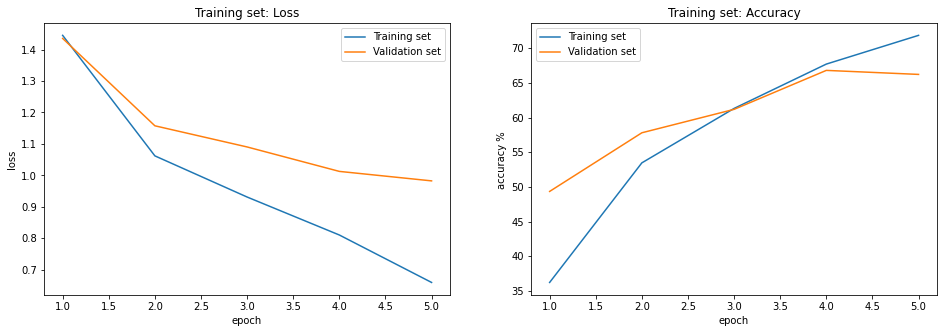

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.85 s Accuracy: 66.39

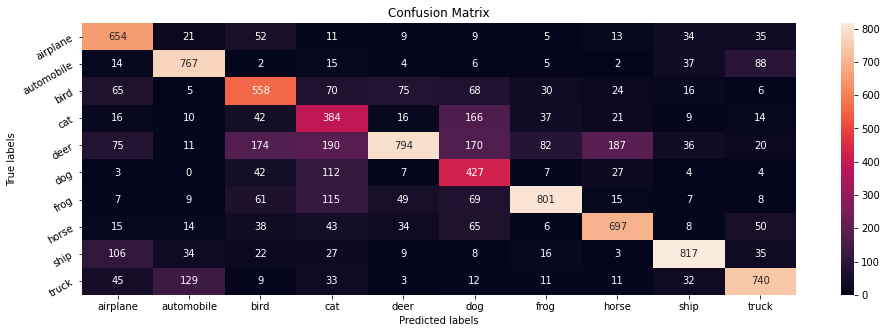

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

### kernel size

In [0]:
#Define network architecture
class CNN_3k(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 5, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - )/1 + 1 = 30
          nn.MaxPool2d(kernel_size=3),
          # 30 / 3 = 10
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, padding=1, stride=1),
          #output layer = (10 + 2*1 - 5)/1 + 1 = 8
          nn.MaxPool2d(kernel_size=4),
          # 8 / 4 = 2  
          nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1, stride=1),
          #output layer = (2 + 2*1 - 3)/1 + 1 = 2
          nn.MaxPool2d(kernel_size=2),
          # 2 / 2 = 1  
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(64*1*1, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN_3k()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 5, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 200------loss: 1.7915152311325073 accuracy: 23.365 %
epoch 0 batch 400------loss: 1.6078376770019531 accuracy: 29.368 %
epoch 1 batch 200------loss: 1.3922228813171387 accuracy: 44.735 %
epoch 1 batch 400------loss: 1.3955445289611816 accuracy: 46.627 %
epoch 2 batch 200------loss: 1.2977811098098755 accuracy: 53.065 %
epoch 2 batch 400------loss: 1.1444122791290283 accuracy: 53.58 %
epoch 3 batch 200------loss: 1.2083940505981445 accuracy: 57.105 %
epoch 3 batch 400------loss: 1.092463493347168 accuracy: 57.555 %
epoch 4 batch 200------loss: 1.2203001976013184 accuracy: 60.03 %
epoch 4 batch 400------loss: 0.9263896346092224 accuracy: 60.322 %
total time elapsed: 73.33 s

Time elapsed for training: 1.222 min, Accuracy: 60.25 %

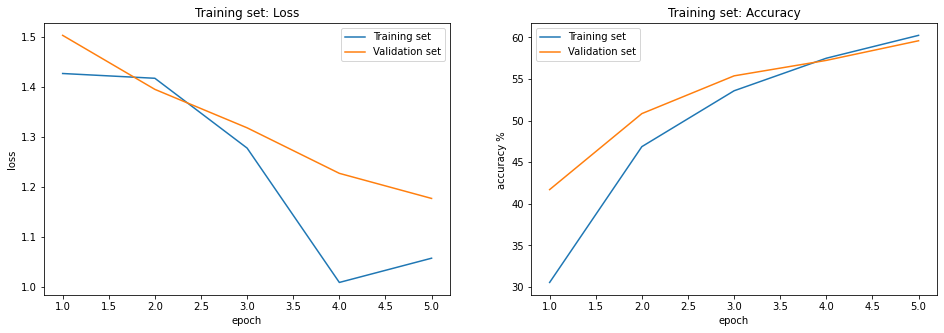

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.3 s Accuracy: 59.25

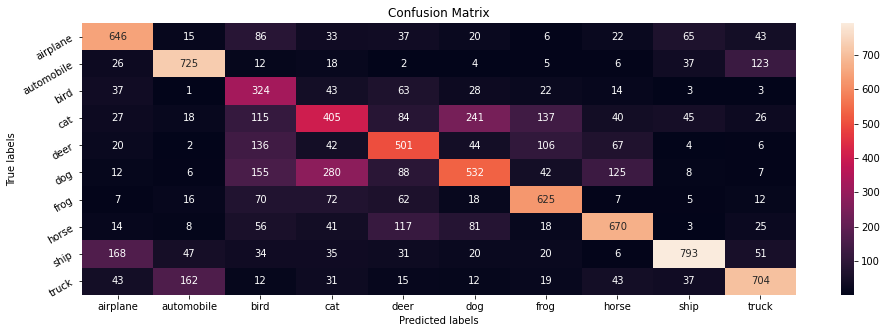

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

## 4 conv layers

In [0]:
#Define network architecture
class CNN_4(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - 3)/1 + 1 = 32
          nn.MaxPool2d(kernel_size=2),
          # 32 / 2 = 16
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
          #output layer = (16 + 2*1 - 3)/1 + 1 = 16
          nn.MaxPool2d(kernel_size=2),
          # 16 / 2 = 8  
          nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1, stride=1),
          #output layer = (8 + 2*1 - 3)/1 + 1 = 8
          nn.MaxPool2d(kernel_size=2),
          # 8 / 2 = 4  
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
          #output layer = (4 + 2*1 - 3)/1 + 1 = 4
          nn.MaxPool2d(kernel_size=2),
          # 4 / 2 = 2  
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(128*2*2, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN_4(dropout=0.5)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 10, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 100------loss: 2.12662935256958 accuracy: 15.6 %
epoch 0 batch 200------loss: 1.9785336256027222 accuracy: 20.205 %
epoch 0 batch 300------loss: 1.6738609075546265 accuracy: 22.997 %
epoch 0 batch 400------loss: 1.6383183002471924 accuracy: 25.738 %
epoch 1 batch 100------loss: 1.5485213994979858 accuracy: 40.35 %
epoch 1 batch 200------loss: 1.4945756196975708 accuracy: 41.575 %
epoch 1 batch 300------loss: 1.2699060440063477 accuracy: 42.84 %
epoch 1 batch 400------loss: 1.4551430940628052 accuracy: 44.035 %
epoch 2 batch 100------loss: 1.1935477256774902 accuracy: 51.94 %
epoch 2 batch 200------loss: 1.5790754556655884 accuracy: 52.815 %
epoch 2 batch 300------loss: 1.2521867752075195 accuracy: 53.38 %
epoch 2 batch 400------loss: 1.4708166122436523 accuracy: 53.997 %
epoch 3 batch 100------loss: 1.4170515537261963 accuracy: 58.85 %
epoch 3 batch 200------loss: 1.0669606924057007 accuracy: 59.32 %
epoch 3 batch 300------loss: 1.2194983959197998 accuracy: 59.277 %
epoch 3 batch 400------loss: 1.0996026992797852 accuracy: 59.52 %
epoch 4 batch 100------loss: 1.0419796705245972 accuracy: 63.52 %
epoch 4 batch 200------loss: 1.1685848236083984 accuracy: 63.785 %
epoch 4 batch 300------loss: 1.0108569860458374 accuracy: 64.217 %
epoch 4 batch 400------loss: 0.8040656447410583 accuracy: 64.645 %
epoch 5 batch 100------loss: 0.8454400897026062 accuracy: 67.8 %
epoch 5 batch 200------loss: 0.7548235058784485 accuracy: 67.78 %
epoch 5 batch 300------loss: 0.8686995506286621 accuracy: 67.593 %
epoch 5 batch 400------loss: 0.9397784471511841 accuracy: 67.635 %
epoch 6 batch 100------loss: 0.8202117681503296 accuracy: 70.95 %
epoch 6 batch 200------loss: 0.7057216167449951 accuracy: 69.91 %
epoch 6 batch 300------loss: 1.1314587593078613 accuracy: 69.837 %
epoch 6 batch 400------loss: 1.0565438270568848 accuracy: 70.23 %
epoch 7 batch 100------loss: 0.8628044128417969 accuracy: 73.5 %
epoch 7 batch 200------loss: 0.8840108513832092 accuracy: 72.89 %
epoch 7 batch 300------loss: 0.7362111806869507 accuracy: 72.96 %
epoch 7 batch 400------loss: 0.7539836764335632 accuracy: 72.785 %
epoch 8 batch 100------loss: 0.6472575664520264 accuracy: 75.24 %
epoch 8 batch 200------loss: 0.8931680917739868 accuracy: 74.82 %
epoch 8 batch 300------loss: 0.8760340809822083 accuracy: 74.623 %
epoch 8 batch 400------loss: 0.8155621886253357 accuracy: 74.603 %
epoch 9 batch 100------loss: 0.5126123428344727 accuracy: 77.09 %
epoch 9 batch 200------loss: 0.8567283749580383 accuracy: 76.985 %
epoch 9 batch 300------loss: 0.6613509654998779 accuracy: 76.56 %
epoch 9 batch 400------loss: 0.8368625640869141 accuracy: 76.457 %
total time elapsed: 186.06 s

Time elapsed for training: 3.101 min, Accuracy: 76.28 %

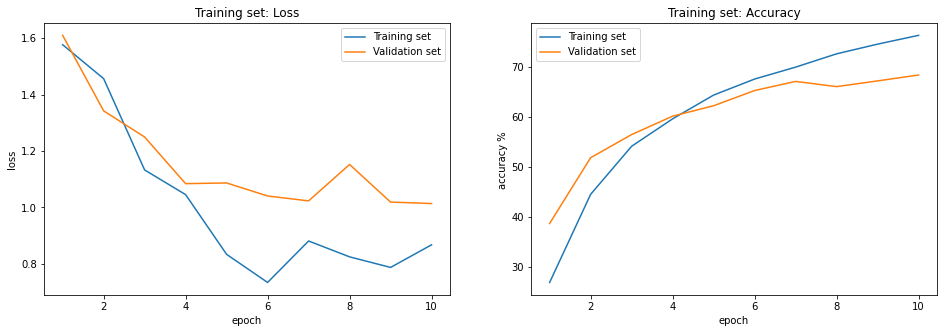

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.95 s Accuracy: 67.2

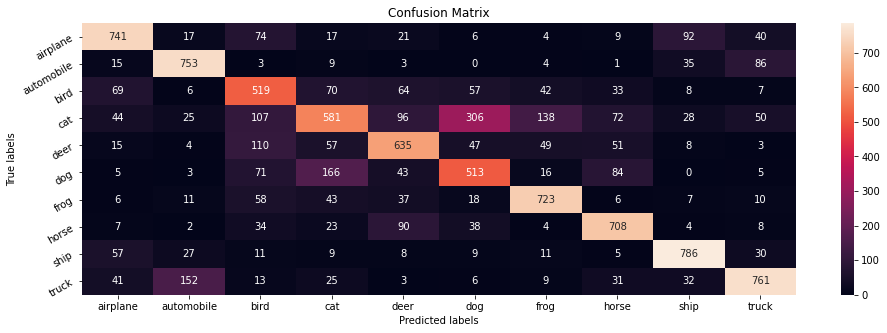

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)